### 7. 트랜스포머
- 트랜스포머(Transformer) : 2017년 코넬 대학의 연구 그룹이 발표한 'Attention Is All You Need' 논문을 통해 발표된 신경망 아키텍처.
- 주요 기능 : 기존의 순환 신경망과 같은 순차적 방식이 아닌 **병렬**로 입력 시퀀스를 처리하는 기능.
- 셀프-어텐션(Self-Attention) 기반 -> 재귀나 합성곱 연산 없이 입력 토큰 간의 관계를 직접 모델링할 수 있음.

**[장점]**
- 대용량 데이터세트에서 매우 효율적, 데이터의 양이 많은 기계 번역과 같은 작업에 적합.
- 언어 모델링 및 텍스트 분류와 같은 작업에서도 매우 효과적, 광범위한 자연어 처리 작업에서 높은 효율을 보임.

**[트랜스포머 기반 모델들의 동작 방식]**
- 오토 인코딩(Auto- Encoding) & 자귀 회귀(Auto Regressive)
- 오토 인코딩 : 랜덤하게 문장의 일부를 빈칸 토큰으로 만들고 해당 빈칸에 어떤 단어가 적절할지 예측하는 작업 수행함. 예측되는 토큰 양옆에 있는 토큰들을 참조하기 때문에 양방향 구조, 이것을 **인코더(Encoder)**라고 함.
- 토큰의 왼쪽에 있는 토큰들만 참조하는 단방향 구조를 가지는 것은 **디코더(Decoder)**.
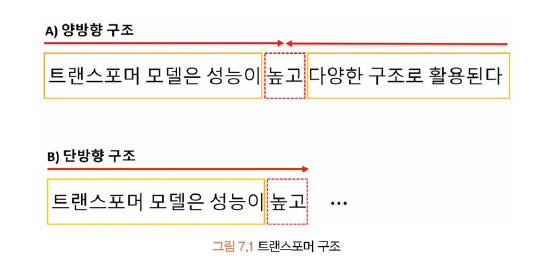

**[트랜스포머의 인코더와 디코더]**
- 각각 N개의 트랜스포머 블록으로 구성되고, 이 블록은 멀티 헤드 어텐션(Multi-Head Attention)과 순방향 신경망으로 이루어져 있음.
- 멀티 헤드 어텐션 : 입력 시퀀스에서 쿼리(Query), 키(Key), 값(Value) 벡터 정의하여 입력 시퀀스들의 관계를 셀프-어텐션하는 벡터 표현 방법. 이 과정에서 쿼리와 각 키의 유사도 계산하고, 해당 유사도를 가중치로 사용하여 값 벡터를 합산함.
- 순방향 신경망 : 임베딩 벡터를 더욱 고도화하기 위해 사용됨. 여러 개의 선형 계층으로 구성되어 있으며, 입력 벡터에 가중치 곱하고, 편향 더하며, 활성화 함수 적용함. 이렇게 학습된 가중치들은 입력 시퀀스의 각 단어의 의미를 잘 파악할 수 있는 방식으로 갱신됨.
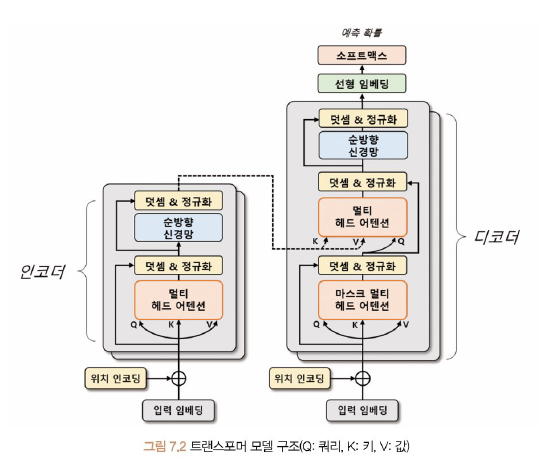

#### 입력 임베딩과 위치 인코딩
- 입력 시퀀스의 각 단어는 임베딩 처리되어 벡터 형태로 변환됨. 트랜스포머는 순환 신경망과 달리 입력 시퀀스를 병렬 구조로 처리하기 때문에 단어의 순서 정보를 제공하지 않음. => 그러므로 **위치 정보**를 임베딩 벡터에 추가해 단어의 순서 정보를 모델에 반영해야 함. => **위치 인코딩** 방식 사용!

**[위치 인코딩]**
- sin 함수와 cos 함수 사용하여 생성되며, 이를 통해 임베딩 벡터와 위치 정보 결합된 최종 입력 벡터를 생성함. => 모델은 단어의 순서 정보 학습할 수 있게 됨.
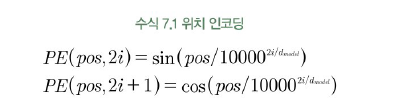
- pos : 입력 시퀀스에서 해당 단어의 위치.
- i : 임베딩 벡터의 차원 인덱스.
- 차원 인덱스 짝수면 첫 번째 sin 함수 수식 적용, 홀수라면 두 번째 cos 함수 수식 적용.

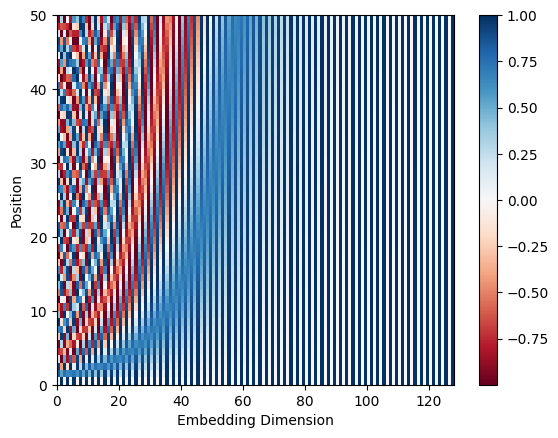

In [1]:
# 위치 인코딩
import math
import torch
from torch import nn
from matplotlib import pyplot as plt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2)*(-math.log(10000.0)/d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # 모델이 매개변수 갱신하지 않도록 설정함.

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


encoding = PositionalEncoding(d_model=128, max_len=50)

plt.pcolormesh(encoding.pe.numpy().squeeze(), cmap='RdBu')
plt.xlabel('Embedding Dimension')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# PositionalEncoding 클래스는 입력 임베딩 차원(d_model), 최대 시퀀스(max_len) 입력 받음.
# 입력 시퀀스 위치마다 sin, cos 함수로 위치 인코딩 계산함.
# pe 변수의 텐서 차원은 [50, 1, 128], [최대 시퀀스, 1, 입력 임베딩의 차원] 의미함.
# 출력 결과 확인) 위치별 임베딩 차원이 주기적인 값으로 구성되는 것 확인 가능.
# 산출된 위치 인코딩은 입력 임베딩과 더해진 후 드롭아웃 적용됨.

**[특수 토큰]**
- 단어 토큰 이외의 특수 토큰 활용하여 문장 표현함.
- 특수 토큰은 입력 시퀀스의 시작과 끝을 나타내거나 **마스킹(Masking)** 영역으로 사용됨.
- 모델이 입력 시퀀스의 시작과 끝을 인식할 수 있도록 하며, 마스킹 통해 일부 입력을 무시할 수 있음.
- ex) BOS(Beginning of Sequence), EOS(End of Sentence), UNK(Unknown) 및 PAD(Padding)
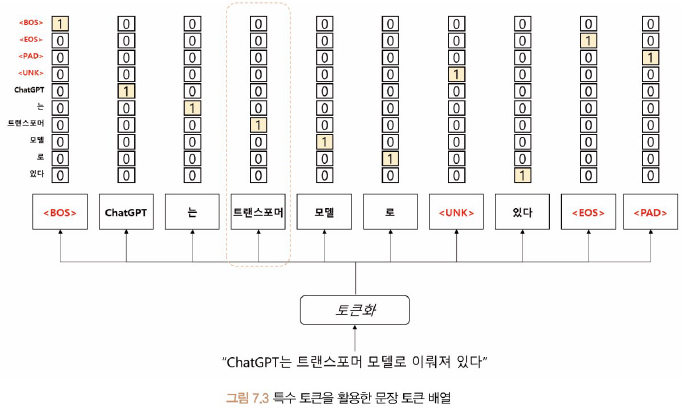

[입력 임베딩으로 변환되는 과정]
- 생성된 문장 토큰 배열을 어휘 사전에 등장하는 위치에 원-핫 인코딩 표현함.
- 어휘 사전 크기 V, 입력 임베딩 차원 d, 원-핫 벡터는 [1, V] 크기 가짐.
- 임베딩 행렬 [V, d]에 의해 [1, d] 크기로 변환. => N개 문장이 최대 S개의 토큰 길이 가질 때 [N, S, V] 크기의 원-핫 벡터 텐서는 [N, S, d] 크기 임베딩 텐서로 변환.

#### 트랜스포머 인코더
- 입력 시퀀스 받아 여러 개 계층으로 구성된 인코더 계층 거쳐 연산 수행.
- 각 인코더 계층은 멀티 헤드 어텐션과 순방향 신경망으로 구성, 입력 데이터에 대한 정보 추출 후 다음 계층으로 전달.
- 인코더 계츠엥 위치 정보 반영하기 위해 위치 임베딩 벡터를 입력 벡터에 더해주고, 인코더 계층의 출력은 디코더 계층으로 전달됨.

**[연산 과정]**
- 쿼리 벡터 : 현재 시점에서 참조하고자 하는 정보의 위치 나타내는 벡터, 인코더 각 시점마다 생성. 현재 시점에서 질문이 되는 벡터.
- 키 벡터 : 쿼리 벡터와 비교되는 대상, 쿼리 벡터 제외한 입력 시퀀스에서 탐색되는 벡터가 됨. 인코더의 각 시점에서 생성.
- 값 벡터 : 쿼리 벡터와 키 벡터로 생성된 어텐션 스코어를 얼마나 반영할지 설정하는 가중치 역할.
- 셀프 어텐션 과정 : 쿼리, 키 벡터로 어텐션 스코어 구하고 이를 소프트맥스 함수 이용하여 확률적으로 재표현, 마지막으로 값 벡터와 내적하여 셀프 어텐션된 벡터 생성.
- 멀티 헤드 : 이러한 셀프 어텐션 여러 번 수행하여 여러 개의 헤드 만들고, 각각의 헤드는 독립적으로 어텐션 수행, 그 결과를 마지막에 합침(병합).
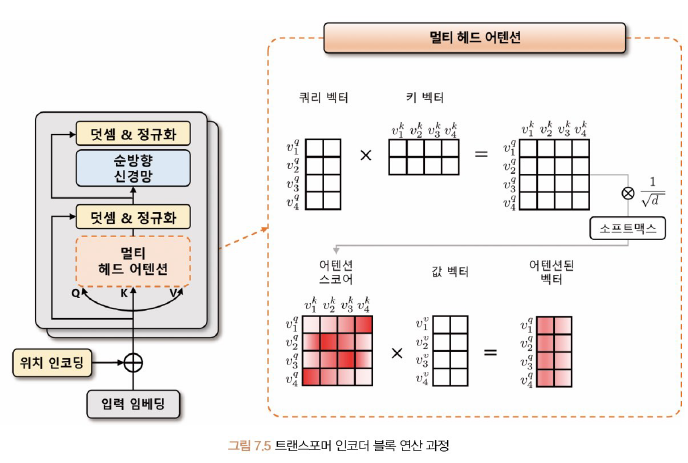

#### 트랜스포머 디코더
- 위치 인코딩 적용된 타깃 데이터의 입력 임베딩 입력받음.
- 위치 인코딩은 입력 시퀀스 내에서 각 단어의 상대적인 위치 정보 전달하는 기법, 디코더의 입력 임베딩에 위치 정보 추가하여 디코더가 입력 시퀀스의 순서 정보 학습할 수 있게 됨.
- 인과성 반영한 **마스크** 멀티 헤드 어텐션 : 어텐션 스코어 맵 계산 시 첫 번째 쿼리 벡터가 첫 번째 키 벡터만 바라볼 수 있게, 두 번째는 첫, 두 번째만 바라볼 수 있게 마스크 씌움. 현재 위치 이전의 단어들만 참조 가능.
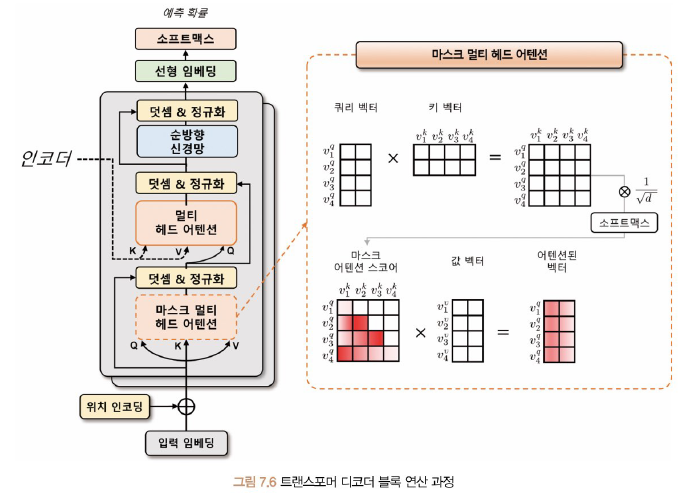

#### 모델 실습
- 영어-독일어 번역 모델 구성
- Multi30k 데이터세트 사용 : 영어-독일어 병렬 말뭉치(Parallel corpus), 약 30,000개 데이터 제공
- 토치 데이터(torchdata), 토치 텍스트(torchtext)라이브러리로 해당 데이터세트 다운로드 가능.

- **토치 데이터 라이브러리** : 대규모 데이터세트 다루기 쉽게 데이터 불러오고 변환 및 배치하는 간단하고 유연한 API 제공.
- **토치 텍스트 라이브러리** : 파이토치 위한 텍스트 처리 라이브러리. 다양한 언어 모델링 작업에 대해 사전 처리 및 데이터처리 및 데이터 세트 관리 단순환하기 위한 도구와 기능 제공.
- **포르타락커(portalocker) 라이브러리** : 파이썬에서 파일 락 관리하기 위한 라이브러리, 파일 락 사용하여 여러 프로세스 간에 동시에 파일 수정 및 읽는 것을 방지함. Multi30k 데이터세트를 다운로드하고 압축 해제하는 과정에서 내부적으로 사용됨.

In [1]:
# Multi30k 데이터를 다루기 위한 torchdata, portalocker 설치
!pip install torchdata portalocker

In [2]:
!pip install torch==2.1.0 torchtext==0.16.0

In [3]:
# 토큰화를 위해 spacy의 독일어 및 영어 모델 설치
!pip install spacy
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 14.6/14.6 MB 204.6 MB/s eta 0:00:01
ERROR: Operation cancelled by user
^C
^C


In [1]:
# 데이터세트 다운로드 및 전처리
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

def generate_tokens(text_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for text in text_iter:
        yield token_transform[language](text[language_index[language]])

SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

token_transform = {
    SRC_LANGUAGE: get_tokenizer('spacy', language='de_core_news_sm'),
    TGT_LANGUAGE: get_tokenizer('spacy', language='en_core_web_sm')
}

print("Token Transform:")
print(token_transform)

vocab_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[language] = build_vocab_from_iterator(
        generate_tokens(train_iter, language),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[language].set_default_index(UNK_IDX)

print("Vocab Transform:")
print(vocab_transform)

Token Transform:
{'de': functools.partial(<function _spacy_tokenize at 0x7b7187c082c0>, spacy=<spacy.lang.de.German object at 0x7b7173bde390>), 'en': functools.partial(<function _spacy_tokenize at 0x7b7187c082c0>, spacy=<spacy.lang.en.English object at 0x7b71737587d0>)}
Vocab Transform:
{'de': Vocab(), 'en': Vocab()}


- 독일어 말뭉치(de_core_news_sm) & 영어 말뭉치(en_core_web_sm)에 대해 각각 토크나이저와 어휘 사전 생성함.
- `get_tokenizer` : 사용자가 지정한 토크나이저 가져오는 유틸리티 함수, spaCy 라이브러리로 사전 학습된 모델 가져옴. -> 이 값을 `token_transform` 변수에 저장.
- `vocab_transform` : 토큰을 인덱스로 변환시키는 함수 저장. Multi30k 데이터세트 활용하여 (독일어, 영어)의 튜플 형식으로 데이터 불러옴.
- `build_vocab_from_iterater` : 생성된 토큰을 이용해 단어 집합 생성. `generate_tokens`와 함께 언어별 어휘 사전 생성하는데 사용.
- `min_freq` : 토큰화된 단어들의 최소 빈도수 지정.
- 특수 토큰(`specials`) : 트랜스포머에 사용되는 특수 토큰 지정, `special_first` 매개변수가 참이면 특수 토큰을 단어 집합 맨 앞에 추가함.
- `set_default_index` : 인덱스 기본값 설정, 어휘 사전에 없는 토큰 `<unk>`의 인덱스 할당함.

In [2]:
# 트랜스포머 모델 구성
import math
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0)]
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long())

class Seq2SeqTransformer(nn.Module):
    def __init__(
            self,
            num_encoder_layers,
            num_decoder_layers,
            emb_size,
            max_len,
            nhead,
            src_vocab_size,
            tgt_vocab_size,
            dim_feedforward,
            dropout=0.1
    ):
        super().__init__()
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            d_model=emb_size, max_len=max_len, dropout=dropout
        )
        self.transformer= nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(
            self,
            src,
            tgt,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            memory_key_padding_mask,
    ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        outs = self.transformer(
            src_emb,
            tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )

**[Seg2SeqTransformer 클래스]**
- **TokenEmbedding 클래스**로 소스 데이터와 입력 데이터를 입력 임베딩으로 변환하여 `src_tok_emb`와 `tgt_tok_emb` 생성함. => 소스와 타깃 데이터의 어휘 사전 크기 입력받아 트랜스포머 임베딩 크기로 변환, 앞에서 정의한 **PositionalEncoding** 적용하여 트랜스포머 블록에 입력.
- 트랜스포머 블록(`self.transformer`) : 파이토치에서 제공하는 트랜스포머(`Transformer`) 클래스를 적용, 인코더와 디코더는 `encoder_layers` 변수 값으로 구성됨.
- 순방향 메서드 마지막에 적용되는 `generator` - 마지막 트랜스포머 디코더 블록에서 산출되는 벡터를 선형 변환해 어휘 사전에 대한 로짓(logit) 생성.

**[트랜스포머 클래스]**


```
transformer = torch.nn.Transformer(
    d_model=512,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=2048,
    dropout=0.1,
    activation=torch.nn.functional.relu,
    layer_norm_eps=1e-05,
)
```

- 임베딩 차원(`d_model`) : 트랜스포머 모델의 입력과 출력 차원의 크기 정의. 임베딩 차원과 동일함.
- 헤드(`nhead`) : 멀티 헤드 어텐션의 헤드 개수 정의. 헤드 개수는 모델이 어텐션 수행하는 방법 결정하며, 헤드 개수 많을수록 모델의 병렬 처리 능력이 증가함.
- 인코더 계층 개수(`num_encoder_layers`)&디코더 계층 개수(`num_decoder_layers`) : 인코더와 디코더의 계층 수 의미. 모델의 복잡도와 성능에 영향을 미침. 계층 개수 많을수록 더 복잡한 문제 해결할 수 있지만, 너무 많으면 과적합 위험.
- 순방향 신경망 크기(`dim_feedforward`) : 순방향 신경망의 은닉층 크기 정의. 트랜스포머 계층의 각 입력 위치에 독립적으로 적용됨.
- 드롭아웃(`dropout`) : 인코더와 디코더 계층에 적용되는 드롭아웃 비율.
- 활성화 함수(`activation`) : 순방향 신경망에 적용되는 활성화 함수
- 계층 정규화 입실론(`layer_norm_eps`) : 계층 정규화 수행할 때 분모에 더해지는 입실론 값을 정의.

**[트랜스포머 순방향 메서드]**


```
output = transformer.forward(
    src,
    tgt,
    src_mask=None,
    tgt_mask=None,
    memory_mask=None,
    src_key_padding_mask=None,
    tgt_key_padding_mask=None,
    memory_key_padding_mask=None,
)
```
- 소스(`src`), 타깃(`tgt`) : 인코더와 디코더에 대한 시퀀스로, [소스(타깃) 스퀀스 길이, 배치 크기, 임베딩 차원] 형태의 데이터를 입력받음.
- 소스 마스크(`src_mask`), 타깃 마스크(`tgt_mask`) : 소스와 타깃 시퀀스의 마스크로, [소스(타깃) 시퀀스 길이, 시퀀스 길이] 형태의 데이터 입력받음.
    - 마스크 값이 0이라면 해당 위치에서는 모든 입력 단어가 동일한 가중치 가지고 어텐션 수행, 1이면 모든 입력 단어 가중치가 0으로 설정되어 어텐션 연산 수행 x.
    - -inf라면 해당 위치에서는 어텐션 연산 결과에 0으로 가중치 부여되어 마스킹된 위치 정보를 모델이 무시하게 만듦.
    - 반대로 +inf 입력하면 모든 입력 단어에 무한대 가중치 부여되어 어텐션 연산 결과가 해당 위치에 대한 정보만으로 구성됨.(일반적으로 이렇게 적용하지는 않고, 특정 단어나 위치에 대해 모델이 특별한 관심 가지도록 할 때만 사용)
- 메모리 마스크(`memory_mask`) : 인코더 출력의 마스크로 [타킷 시퀀스 길이, 소스 시퀀스 길이] 형태, 메모리 마스크 0인 위치에서는 어텐션 연산 수행 x.
- 소스, 타깃, 메모리 키 패딩 마스크(`key_padding_mask`) : 소스, 타깃, 메모리 시퀀스에 대한 패딩 마스크 의미. [배치 크기, 소스(타깃) 시퀀스 길이] 형태 데이터 입력받고, 메모리 키 패딩 마스크는 소스 키 패딩 마스크와 동일한 형태의 데이터 입력받음.    
    - 키 패딩 마스크는 입력 시퀀스에서 패딩 토큰 위치한 부분을 가리키는 이진 마스크로, 패딩 토큰이 실제 의미를 가지지 않는 것으로 간주되어 해당 위치 어텐션 연산 결과에 대한 가중치 0으로 만듦.


In [3]:
# 트랜스포머 모델 구조
from torch import optim

BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else 'cpu'

model = Seq2SeqTransformer(
    num_encoder_layers=3,
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=512,
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = optim.Adam(model.parameters())

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("->", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("| ->", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("| | ->", sssub_name)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


src_tok_emb
-> embedding
tgt_tok_emb
-> embedding
positional_encoding
-> dropout
transformer
-> encoder
| -> layers
| | -> 0
| | -> 1
| | -> 2
| -> norm
-> decoder
| -> layers
| | -> 0
| | -> 1
| | -> 2
| -> norm
generator


<Seq2SeqTransformer 클래스>
- 입력 임베딩(`src_tok_emb`, `tgt_tok_emb`), 위치 인코딩(`positional_encoding`), 트랜스포머 블록(`transformer`), 로짓 생성(`generator`) 구성
- 인코더와 디코더가 각각 3개(0, 1, 2) 계층으로 구성됨.
- 손실 함수: 교차 엔트로피 함수 적용
- 무시되는 색인(`ignore_index`) 값을 패딩 토큰(PAD_IDX) 할당하여 모델이 학습하는 동안 무시해야 할 클래스 레이블 지정함.
    - 패딩 토큰은 모델 학습에 사용되지 않으므로 해당 토큰에 대한 레이블 무시하고 모델이 해당 클래스 학습하지 않게 함.

In [4]:
# 배치 데이터 생성
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def input_transform(token_ids):
    return torch.cat(
        (torch.tensor([BOS_IDX]),
         torch.tensor(token_ids),
         torch.tensor([EOS_IDX]))
    )

def collator(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch


text_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[language] = sequential_transforms(
        token_transform[language],
        vocab_transform[language],
        input_transform
    )

data_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)
source_tensor, target_tensor = next(iter(dataloader))

print("(source, target):")
print(next(iter(data_iter)))

print("source_batch:", source_tensor.shape)
print(source_tensor)

print("target_batch:", target_tensor.shape)
print(target_tensor)

(source, target):
('Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen', 'A group of men are loading cotton onto a truck')
source_batch: torch.Size([35, 128])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [  14,    5,    5,  ...,    5,   21,    5],
        [  38,   12,   35,  ...,   12, 1750,   69],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])
target_batch: torch.Size([30, 128])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   6,    6,    6,  ...,  250,   19,    6],
        [  39,   12,   35,  ...,   12, 3254,   61],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


/usr/local/lib/python3.11/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


- `sequential_transforms` 함수: 여러 개의 전처리 함수 인자로 받아 이를 차례로 적용하는 함수를 반환하는 함수. 여기서는 세 종류의 전처리 수행함.
    - `token_transform` 적용하여 문장 토큰화
    - `vocab_transform` 적용하여 각 토큰 인덱스화
    - `input_transform` 적용하여 인덱스화된 토큰에 문장 시작 BOS_IDX(2)와 끝 EOS_IDX(3) 알리는 특수 토큰 할당

- `data_iter` 변수에 (독일어, 영어) 형태로 Multi30k 텍스트 데이터세트 불러옴. 이를 데이터로더에 적용, 집합 함수는 collator 적용함.
- `collator` 함수 : 배치 단위로 데이터 처리함.
    - `rstrip('\n')` 함수로 문자열 끝에 있는 개행 문자(\n) 제거
    - `text_transform` 변수에 저장된 `sequential_transforms` 함수 적용
- 패딩 시퀀스(`pad_sequence`) 함수 : 동일한 길이 가지도록 시퀀스 뒤쪽에 PAD_IDX(1)로 채워진 패딩 토큰 추가 -> 소스와 타깃 시퀀스 패딩함.
- (패딩 적용된 소스, 패딩 적용된 타깃) 튜플 반환함.

In [5]:
# 어텐션 마스크 생성
def generate_square_subsequent_mask(s):
    mask = (torch.triu(torch.ones((s,s), device=DEVICE)) == 1).transpose(0,1)
    mask = (
        mask.float()
        .masked_fill(mask == 0, float('-inf'))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0,1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0,1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


target_input = target_tensor[:-1, :]
target_out = target_tensor[1:, :]

source_mask, target_mask, source_padding_mask, target_padding_mask = create_mask(
    source_tensor, target_input)

print("source_mask:", source_mask.shape)
print(source_mask)
print("target_mask:", target_mask.shape)
print(target_mask)
print("source_padding_mask:", source_padding_mask.shape)
print(source_padding_mask)
print("target_padding_mask:", target_padding_mask.shape)
print(target_padding_mask)

source_mask: torch.Size([35, 35])
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')
target_mask: torch.Size([29, 29])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf,

**[마스크 생성하는 함수와 두 시퀀스의 패딩 마스크 생성하는 함수]**
- 마스크 생성 함수 -> `generate_square_subsequent_mask`: 입력으로 정수 s 받아 sxs 크기의 마스크 생성.
    - `torch.ones` 함수 사용하여 1로 채워진 행렬 만들고 `torch.triu` 함수 적용하여 상삼각행렬(주대각선 기준으로 대각선 위쪽 또는 아래쪽 항이 모두 0인 행렬) 생성함.
    - 마지막으로 `transpose` 사용하여 행렬 전치.
- 마스크 텐서에서 0인 값은 -inf, 1인 값은 0.0으로 채워 어텐션 연산 적용.
- 0.0 설정된 값은 셀프 어텐션에 참조되는 시퀀스, -inf 값은 그 과정에서 어텐션 스코어가 0으로 수렴하므로 제외됨.

- 패딩 마스크 생성 함수 -> `create_mask`: 시퀀스 입력받아 길이 계산하고 마스크 생성 함수로 타깃 시퀀스 마스크 생성함.
    - 소스 마스크: 소스 시퀀스 길이 크기로 채워진 행렬 생성
    - 패딩 마스크: 각 시퀀스에 대해 패딩 토큰의 위치 찾고 `transpose` 함수로 전치시킴.
    - 패딩 마스크 생성 전 타깃 데이터 입력값(target_input)과 출력값(target_out)은 토큰 순서를 한 칸 시프트(shift)하여 이전 토큰들이 주어졌을 때 다음 토큰 예측하게 함.

 - `source_tensor`, `target_input` 전달하여 4개의 텐서 생성시킴.
    - `source_mask`: 셀프 어텐션 과정에서 참조되는 소스 데이터 시퀀스 범위. False 위치는 셀프 어텐션에 참조되는 토큰, True 위치는 제외되는 토큰.
    - `target_mask`: [쿼리 시퀀스 길이, 키 시퀀스 길이] 형태로 구성, i번째 쿼리 벡터는 i+1 이상의 키 벡터에 대해 어텐션 연산 수행 x.
    - `source_padding_mask`
    - `target_padding_mask`
        - 소스(타깃) 배치 데이터에서 텍스트 토큰이 존재하는지 여부 나타내는 값.
        - False : 해당 토큰 인덱스 존재.
        - True : 해당 토큰 인덱스가 패딩 토큰으로 채워져 있음.

In [6]:
# 모델 학습 및 평가
def run(model, optimizer, criterion, split):
    model.train() if split == 'train' else model.eval()
    data_iter = Multi30k(split=split, language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)

    losses = 0
    for source_batch, target_batch in dataloader:
        source_batch = source_batch.to(DEVICE)
        target_batch = target_batch.to(DEVICE)

        target_input = target_batch[:-1, :]
        target_output = target_batch[1:, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            source_batch, target_input
        )

        logits = model(
            src=source_batch,
            tgt=target_input,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            src_padding_mask=src_padding_mask,
            tgt_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
        )

        optimizer.zero_grad()
        loss = criterion(
            logits.reshape(-1, logits.shape[-1]),
            target_output.reshape(-1))
        if split == 'train':
            loss.backward()
            optimizer.step()
        losses += loss.item()

    return losses / len(list(dataloader))


for epoch in range(5):
    train_loss = run(model, optimizer, criterion, 'train')
    val_loss = run(model, optimizer, criterion, 'valid')
    print(f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 4.874, Val loss: 4.186
Epoch: 2, Train loss: 3.955, Val loss: 3.806
Epoch: 3, Train loss: 3.633, Val loss: 3.681
Epoch: 4, Train loss: 3.454, Val loss: 3.661
Epoch: 5, Train loss: 3.334, Val loss: 3.633


- `run` 함수 : 모델 학습 및 평가를 위한 함수, 소스와 타깃 데이터 입력받아 collator로 문장들을 토큰화하고 인덱스로 변환.
- `create_mask` 함수 : 트랜스포머 모델에 필요한 입력 패딩 마스크(src_padding_mask, tgt_padding_mask)와 어텐션 마스크(src_mask, tgt_mask) 생성. 이 결괏값들은 타깃 시퀀스 i번째까지 토큰 주어졌을 때 i+1번째 토큰 예측하는 데 활용됨.
- **출력 결과)** 에포크 5까지 모델 학습 시 학습 손실과 검증 손실 모두 감소함.

In [10]:
# 트랜스포머 모델 번역 결과
def greedy_decode(model, source_tensor, source_mask, max_len, start_symbol):
    source_tensor = source_tensor.to(DEVICE)
    source_mask = source_mask.to(DEVICE)

    memory = model.encode(source_tensor, source_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len - 1):
        memory = memory.to(DEVICE)
        target_mask = generate_square_subsequent_mask(ys.size(0))
        target_mask = target_mask.type(torch.bool).to(DEVICE)

        out = model.decode(ys, memory, target_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item

        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(source_tensor.data).fill_(next_word())], dim=0
        )
        if next_word == EOS_IDX:
            break
    return ys

def translate(model, source_sentence):
    model.eval()
    source_tensor = text_transform[SRC_LANGUAGE](source_sentence).view(-1, 1)
    num_tokens = source_tensor.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, source_tensor, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX
    ).flatten()
    output = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))

    return " ".join(output).replace("<bos>", "").replace("<eos>", "")

output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .")
output = translate(model, "Eine Gruppe von Menschen steht vor einem Gebäude .")
print(output_oov)
print(output)

 A man is sitting on a bench .  .  .  . 
 A man is sitting on a bench .  .  .  . 


- 모델 번역 방식 : **그리드 디코딩(Greedy decoding)**
    - 디코더 네트워크가 생성한 확률 분포에서 가장 높은 확률 가지는 단어를 선택하는 방법, 현재 시점에서 가장 확률이 높은 단어를 선택하여 디코딩 진행함.
    - 추론 방식: 디코더에 참조되는 마지막 인코더 트랜스포머 블록의 벡터(`memory`), 타깃 데이터의 입력 텐서(ys), 타깃 마스크(`target_mask`) 사용함.
- memory 텐서 생성하려면 소스 문장을 토큰 인덱스로 표현한 `source_tensor` 생성하고, `source_mask`는 소스 문장에서 모든 토큰이 어텐션될 수 있게 0 값으로 설정.
- `model.decode` 메서드에서 생성된 out은 [ 토큰 개수, 배치 크기, 확률] 형태. 이 값을 transpose 함수 이용하여 [배치 크기, 토큰 개수, 확률] 형태로 변환 후, 텐서 슬라이싱하여 [배치 크기, 확률] 형태로 만듦. 이후, 어휘 사전에서 가장 확률이 높은 토큰 인덱스 찾음.

- 이 과정을 `max_len` 이전이거나 EOS_IDX 예측할 때까지 반복, 최종적으로 예측된 토큰 시퀀스 반환.
- `max_len => num_tokens + 5` : 일반적으로 생성된 문장 길이가 소스 문장 길이보다 약간 더 길어지는 경우가 많기 때문에 5 더함.
- greedy_decode 함수는 현재까지 예측된 토큰들 이용하여 다음 토큰 예측하는데, 이때 가장 높은 확률 가지는 단어 선택하여 다음 토큰으로 예측.
- 마지막으로 예측된 토큰 인덱스를 어휘 사전의 lookup_tokens 함수 통해 텍스트로 반환.
후처리로 `<bos>`와 `<eos>` 토큰은 슬라이싱으로 제거함.
- 이렇게 처리된 텍스트 공백 구분하여 하나의 문장으로 만들고 반환.


**[번역 결과]**
- 잘못된 번역 결과 도출.
- 이글루(Iglu): OOV 데이터로 학습하지 않았기에 부정확할 수 있음.
- 이글루 대신 건물(Gebäude) 입력하여 번역하면 올바르게 파악한 것을 볼 수 있음.
- 더 정확한 번역 위해 더 많은 학습 데이터 사용하거나 모델 구조 또는 하이퍼파라미터 변경하여 성능 모니터링하고 개선해야 함.